In [1]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

In [6]:
#Parameters
#global kx,mu, m, t, alR, B, kF, a, al, delta, phi, delL, delR, nu0, tL, tR, NJ, eye2, s1, s2, s3, tP, tM, t3

kx=0.

mu=1.8
m=.5
t=3
alR=0.
def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
B=2     #looped
kF=np.sqrt(2*m*mu)

a=1/np.sqrt(2*m*t)
al=alR/a

delta=0.5
phi=0    #looped
def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
nu0=m/(2*np.pi)
def xiE(En):
    return kF/(m*cmath.sqrt(delta**2-En**2))

tL=2#in a single site system, tL>delta. in a mutliple sites case, delta>GammaL
tR=2
GammaL=np.pi*nu0*tL**2 #=m*tL**2/2
GammaR=np.pi*nu0*tR**2 #=m*tR**2/2

NJ=1

ET=np.pi/2*kF/m/(NJ*a)

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [7]:
#Junction
def HJ0(kx,B):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
Hy=-t*t3+1j*al/2*np.kron(s3,s1)


def HJ(kx,B):
    start=cmm(HJ0(kx,B))
    HJs=start
    for n in range(2,NJ+1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy)])
        CT=sp.hstack([OT.transpose(),cmm(Hy.conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx,B):
    return En*np.eye(4*NJ)-HJ(kx,B).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF*a)*(cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF+kx)))+cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF-kx))))-1j

def gSC1m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi,B):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx,B),gSC2m1(En,kx,phi))+mHt.toarray()

In [8]:
L=201 #phi decimation
phiarray=np.arange(L+1)*2*np.pi/L#/5+np.pi*4/5
EJdisp=np.zeros((4*(NJ+2),L+1)) #2*NJ when single site =1 & 4*NJ when mutliple sites
q=0
M=20
Barray=np.arange(M+1)*4*ET/M
PDphi=np.zeros(M+1)
PDB=np.zeros(M+1)

for qq in range(M+1):
    B=Barray[qq]
    for j in range(L+1):
        print(j)
        ekx=[]
        phi=phiarray[j]
        def fdet(En):
            return np.linalg.det(Gtotm1(En,kx,phi,B))/(mu**(8*NJ)) #here change between isolated junction and total system
        #jtmm=[-5+0.1*opq for opq in range(51)]
        x0roots=np.ndarray.tolist(np.linspace(-delta,delta,np.int(2*delta/0.01)))
        #x0roots.extend(jtmm)
        for i in range(len(x0roots)):
            x0=x0roots[i]
            solekx=opt.fsolve(fdet,np.asarray(x0))
            if abs(fdet(solekx))>10**(-6) or abs(solekx)>=delta:
                solekx=[]
            solekx=np.ndarray.tolist(np.around(solekx,3))
            ekx.extend(solekx)
        ekx=list(set(ekx))
        print(ekx)
        if len(ekx)<4*(NJ+2):
            zerocompletion=[delta]*(4*(NJ+2)-len(ekx))
            ekx.extend(zerocompletion)
        elif len(ekx)>4*(NJ+2):
            print("Too many roots.")
            break
        for p in range(4*(NJ+2)):
            EJdisp[p,j]=np.asarray(ekx[p])

        #extracting the gap
        zerogap=0.005
        truegap=min(np.abs(np.asarray(ekx)))
        if truegap<zerogap:
            PDphi[q]=phi
            PDB[q]=B
            q+=1

0


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in divide
/usr/local/lib64/python2.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib64/python2.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[]
1
[]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[0.497, -0.497]
13
[0.496, -0.496]
14
[0.495, -0.495]
15
[0.494, -0.494]
16
[0.493, -0.493]
17
[-0.492, 0.492]
18
[-0.491, 0.491]
19
[-0.489, 0.489]
20
[-0.488, 0.488]
21
[0.486, -0.486]
22
[0.484, -0.484]
23
[0.482, -0.482]
24
[-0.48, 0.48]
25
[-0.478, 0.478]
26
[-0.476, 0.476]
27
[0.473, -0.473]
28
[0.471, -0.471]
29
[-0.468, 0.468]
30
[-0.465, 0.465]
31
[0.462, -0.462]
32
[0.459, -0.459]
33
[-0.456, 0.456]
34
[0.453, -0.453]
35
[0.449, -0.449]
36
[-0.446, 0.446]
37
[-0.442, 0.442]
38
[0.438, -0.438]
39
[-0.434, 0.434]
40
[0.43, -0.43]
41
[0.426, -0.426]
42
[-0.422, 0.422]
43
[0.417, -0.417]
44
[-0.413, 0.413]
45
[-0.408, 0.408]
46
[0.403, -0.403]
47
[-0.398, 0.398]
48
[0.393, -0.393]
49
[-0.388, 0.388]
50
[0.383, -0.383]
51
[-0.378, 0.378]
52
[0.372, -0.372]
53
[-0.367, 0.367]
54
[0.361, -0.361]
55
[-0.355, 0.355]
56
[0.349, -0.349]
57
[-0.343, 0.343]
58
[0.337, -0.337]
59
[-0.331, 0.331]
60
[0.325, -0.325]
61
[-0.318, 0

[-0.408, -0.273, 0.408, 0.273]
147
[0.28, -0.412, 0.412, -0.28]
148
[-0.287, -0.416, 0.416, 0.287]
149
[-0.42, 0.294, 0.42, -0.294]
150
[0.301, -0.424, -0.301, 0.424]
151
[-0.308, 0.428, -0.428, 0.308]
152
[-0.432, 0.315, -0.315, 0.432]
153
[-0.321, -0.436, 0.436, 0.321]
154
[0.328, 0.439, -0.439, -0.328]
155
[-0.443, 0.334, 0.443, -0.334]
156
[0.34, -0.34, -0.446, 0.446]
157
[0.449, 0.347, -0.449, -0.347]
158
[0.452, -0.353, 0.353, -0.452]
159
[-0.455, 0.359, -0.359, 0.455]
160
[-0.365, -0.458, 0.458, 0.365]
161
[0.37, 0.461, -0.461, -0.37]
162
[-0.376, 0.376, 0.464, -0.464]
163
[-0.466, 0.381, -0.381, 0.466]
164
[-0.387, -0.469, 0.469, 0.387]
165
[-0.392, 0.392, -0.471, 0.471]
166
[-0.397, 0.397, 0.473, -0.473]
167
[-0.476, 0.402, -0.402, 0.476]
168
[-0.478, 0.407, 0.478, -0.407]
169
[-0.48, -0.412, 0.412, 0.48]
170
[0.417, -0.481, 0.481, -0.417]
171
[-0.421, 0.483, -0.483, 0.421]
172
[0.426, 0.485, -0.426, -0.485]
173
[0.43, -0.43, 0.486, -0.486]
174
[-0.488, 0.488, -0.434, 0.434]
1

[0.214, -0.214]
29
[0.209, -0.209]
30
[0.203, -0.203]
31
[0.198, 0.494, -0.494, -0.198]
32
[0.192, 0.493, -0.493, -0.192]
33
[0.186, -0.492, 0.492, -0.186]
34
[0.491, -0.491, 0.18, -0.18]
35
[-0.491, 0.174, -0.174, 0.491]
36
[-0.49, 0.168, -0.168, 0.49]
37
[-0.489, 0.162, -0.162, 0.489]
38
[0.156, -0.156, 0.487, -0.487]
39
[0.15, 0.486, -0.15, -0.486]
40
[0.485, -0.143, 0.143, -0.485]
41
[-0.137, 0.484, -0.484, 0.137]
42
[-0.131, -0.482, 0.482, 0.131]
43
[0.124, -0.481, 0.481, -0.124]
44
[-0.48, -0.117, 0.117, 0.48]
45
[-0.478, 0.111, 0.478, -0.111]
46
[-0.476, 0.476, 0.104, -0.104]
47
[0.475, -0.097, 0.097, -0.475]
48
[0.09, 0.473, -0.473, -0.09]
49
[0.471, -0.083, -0.471, 0.083]
50
[0.076, -0.469, 0.469, -0.076]
51
[-0.467, 0.07, -0.07, 0.467]
52
[-0.465, 0.465, -0.063, 0.063]
53
[-0.056, 0.463, 0.056, -0.463]
54
[0.048, 0.461, -0.461, -0.048]
55
[0.041, -0.458, 0.458, -0.041]
56
[0.034, -0.034, -0.456, 0.456]
57
[-0.027, 0.453, 0.027, -0.453]
58
[-0.02, 0.451, 0.02, -0.451]
59
[0.44

[-0.341, -0.299, 0.299, 0.341]
98
[0.338, 0.302, -0.302, -0.338]
99
[0.335, 0.305, -0.335, -0.305]
100
[-0.307, -0.334, 0.334, 0.307]
101
[-0.307, -0.334, 0.334, 0.307]
102
[0.335, 0.305, -0.335, -0.305]
103
[0.338, 0.302, -0.302, -0.338]
104
[-0.341, -0.299, 0.299, 0.341]
105
[-0.295, 0.295, -0.345, 0.345]
106
[0.349, 0.29, -0.29, -0.349]
107
[-0.353, -0.286, 0.286, 0.353]
108
[0.357, 0.281, -0.357, -0.281]
109
[0.361, -0.276, 0.276, -0.361]
110
[0.271, -0.365, 0.365, -0.271]
111
[-0.266, 0.266, 0.369, -0.369]
112
[-0.261, 0.261, 0.372, -0.372]
113
[-0.376, 0.256, -0.256, 0.376]
114
[-0.25, 0.25, -0.38, 0.38]
115
[-0.245, 0.245, 0.384, -0.384]
116
[0.388, -0.388, -0.24, 0.24]
117
[0.391, -0.234, -0.391, 0.234]
118
[0.395, -0.229, 0.229, -0.395]
119
[-0.399, -0.223, 0.223, 0.399]
120
[0.402, -0.218, -0.402, 0.218]
121
[0.405, -0.212, 0.212, -0.405]
122
[-0.409, 0.409, 0.207, -0.207]
123
[-0.201, -0.412, 0.201, 0.412]
124
[-0.195, -0.415, 0.415, 0.195]
125
[0.419, -0.19, 0.19, -0.419]
1

[0.039, -0.039]
173
[0.035, -0.035]
174
[0.032, -0.032]
175
[0.029, -0.029]
176
[-0.025, 0.025]
177
[-0.022, 0.022]
178
[0.019, -0.019]
179
[0.016, -0.016]
180
[0.014, -0.014]
181
[-0.011, 0.011]
182
[0.008, -0.008]
183
[0.006, -0.006]
184
[0.003, -0.003]
185
[0.001, -0.001]
186
[0.001, -0.001]
187
[0.003, -0.003]
188
[-0.005, 0.005]
189
[0.007, -0.007]
190
[0.008, -0.008]
191
[-0.01, 0.01]
192
[-0.011, 0.011]
193
[0.012, -0.012]
194
[0.013, -0.013]
195
[0.014, -0.014]
196
[-0.015, 0.015]
197
[0.016, -0.016]
198
[0.016, -0.016]
199
[0.016, -0.016]
200
[-0.017, 0.017]
201
[-0.017, 0.017]
0
[-0.083, 0.083]
1
[-0.083, 0.083]
2
[0.084, -0.084]
3
[0.084, -0.084]
4
[0.084, -0.084]
5
[-0.085, 0.085]
6
[-0.085, 0.085]
7
[-0.086, 0.086]
8
[0.087, -0.087]
9
[-0.088, 0.088]
10
[-0.089, 0.089]
11
[0.09, -0.09]
12
[-0.091, 0.091]
13
[0.093, -0.093]
14
[-0.094, 0.094]
15
[0.096, -0.096]
16
[-0.097, 0.097]
17
[0.099, -0.099]
18
[0.101, -0.101]
19
[-0.103, 0.103]
20
[-0.105, 0.105]
21
[0.107, -0.107]


[-0.455, -0.345, 0.345, 0.455]
80
[0.453, 0.348, -0.348, -0.453]
81
[-0.351, 0.452, 0.351, -0.452]
82
[-0.354, 0.45, -0.45, 0.354]
83
[-0.357, 0.448, -0.448, 0.357]
84
[0.36, -0.446, 0.446, -0.36]
85
[-0.363, -0.444, 0.363, 0.444]
86
[-0.442, 0.442, -0.366, 0.366]
87
[0.369, 0.44, -0.369, -0.44]
88
[0.372, 0.438, -0.438, -0.372]
89
[-0.375, 0.375, -0.436, 0.436]
90
[-0.434, -0.378, 0.378, 0.434]
91
[-0.431, 0.38, -0.38, 0.431]
92
[0.429, 0.383, -0.383, -0.429]
93
[-0.386, 0.386, 0.427, -0.427]
94
[0.425, -0.389, -0.425, 0.389]
95
[0.391, -0.423, -0.391, 0.423]
96
[-0.42, 0.42, 0.394, -0.394]
97
[0.396, -0.396, 0.418, -0.418]
98
[-0.398, 0.416, -0.416, 0.398]
99
[-0.4, 0.415, -0.415, 0.4]
100
[0.414, -0.401, -0.414, 0.401]
101
[0.414, -0.401, -0.414, 0.401]
102
[-0.4, 0.415, -0.415, 0.4]
103
[-0.398, 0.416, -0.416, 0.398]
104
[0.396, -0.396, 0.418, -0.418]
105
[-0.42, 0.42, 0.394, -0.394]
106
[0.391, -0.423, -0.391, 0.423]
107
[0.425, -0.389, -0.425, 0.389]
108
[-0.386, 0.386, 0.427, -0

[0.268, -0.268]
162
[0.266, -0.266]
163
[-0.264, 0.264]
164
[-0.261, 0.261]
165
[0.259, -0.259]
166
[0.257, -0.257]
167
[0.255, -0.255]
168
[-0.253, 0.253]
169
[-0.251, 0.251]
170
[0.249, -0.249]
171
[0.247, -0.247]
172
[-0.245, 0.245]
173
[0.243, -0.243]
174
[0.242, -0.242]
175
[-0.24, 0.24]
176
[-0.238, 0.238]
177
[0.237, -0.237]
178
[-0.235, 0.235]
179
[-0.234, 0.234]
180
[0.232, -0.232]
181
[0.231, -0.231]
182
[0.23, -0.23]
183
[-0.228, 0.228]
184
[-0.227, 0.227]
185
[0.226, -0.226]
186
[0.225, -0.225]
187
[0.224, -0.224]
188
[-0.223, 0.223]
189
[-0.222, 0.222]
190
[-0.221, 0.221]
191
[-0.221, 0.221]
192
[0.22, -0.22]
193
[0.219, -0.219]
194
[0.219, -0.219]
195
[-0.218, 0.218]
196
[-0.218, 0.218]
197
[-0.218, 0.218]
198
[-0.217, 0.217]
199
[-0.217, 0.217]
200
[-0.217, 0.217]
201
[-0.217, 0.217]
0
[-0.262, 0.262]
1
[-0.262, 0.262]
2
[-0.262, 0.262]
3
[-0.262, 0.262]
4
[-0.262, 0.262]
5
[-0.262, 0.262]
6
[-0.263, 0.263]
7
[-0.263, 0.263]
8
[-0.264, 0.264]
9
[-0.264, 0.264]
10
[-0.265

[-0.467, 0.467, 0.418, -0.418]
86
[-0.42, -0.466, 0.42, 0.466]
87
[-0.465, 0.465, -0.422, 0.422]
88
[0.464, -0.424, 0.424, -0.464]
89
[0.426, 0.462, -0.426, -0.462]
90
[0.427, 0.461, -0.461, -0.427]
91
[0.46, 0.429, -0.46, -0.429]
92
[-0.431, 0.431, -0.458, 0.458]
93
[-0.432, -0.457, 0.457, 0.432]
94
[0.456, -0.456, -0.434, 0.434]
95
[-0.454, 0.454, -0.436, 0.436]
96
[0.453, 0.437, -0.437, -0.453]
97
[0.452, 0.439, -0.439, -0.452]
98
[0.44, 0.45, -0.45, -0.44]
99
[0.441, 0.449, -0.449, -0.441]
100
[-0.442, 0.442, 0.449, -0.449]
101
[-0.442, 0.442, 0.449, -0.449]
102
[0.441, 0.449, -0.449, -0.441]
103
[0.44, 0.45, -0.45, -0.44]
104
[0.452, 0.439, -0.439, -0.452]
105
[0.453, 0.437, -0.437, -0.453]
106
[-0.454, 0.454, -0.436, 0.436]
107
[0.456, -0.456, -0.434, 0.434]
108
[-0.432, -0.457, 0.457, 0.432]
109
[-0.431, 0.431, -0.458, 0.458]
110
[0.46, 0.429, -0.46, -0.429]
111
[0.427, 0.461, -0.461, -0.427]
112
[0.426, 0.462, -0.426, -0.462]
113
[0.464, -0.424, 0.424, -0.464]
114
[-0.465, 0.46

[0.328, -0.328]
190
[0.328, -0.328]
191
[0.327, -0.327]
192
[0.327, -0.327]
193
[0.326, -0.326]
194
[0.326, -0.326]
195
[0.326, -0.326]
196
[0.325, -0.325]
197
[0.325, -0.325]
198
[0.325, -0.325]
199
[0.325, -0.325]
200
[0.325, -0.325]
201
[0.325, -0.325]
0
[0.348, -0.348]
1
[0.348, -0.348]
2
[0.348, -0.348]
3
[0.348, -0.348]
4
[0.348, -0.348]
5
[0.348, -0.348]
6
[0.348, -0.348]
7
[0.349, -0.349]
8
[0.349, -0.349]
9
[0.349, -0.349]
10
[0.35, -0.35]
11
[0.35, -0.35]
12
[0.35, -0.35]
13
[-0.351, 0.351]
14
[-0.351, 0.351]
15
[-0.352, 0.352]
16
[-0.352, 0.352]
17
[-0.353, 0.353]
18
[-0.354, 0.354]
19
[-0.354, 0.354]
20
[-0.355, 0.355]
21
[-0.356, 0.356]
22
[-0.356, 0.356]
23
[0.357, -0.357]
24
[0.358, -0.358]
25
[0.359, -0.359]
26
[0.36, -0.36]
27
[0.361, -0.361]
28
[0.361, -0.361]
29
[0.362, -0.362]
30
[-0.363, 0.363]
31
[-0.364, 0.364]
32
[-0.365, 0.365]
33
[-0.366, 0.366]
34
[0.368, -0.368]
35
[0.369, -0.369]
36
[0.37, -0.37]
37
[0.371, -0.371]
38
[0.372, -0.372]
39
[0.373, -0.373]
40
[

[-0.456, 0.472, -0.472, 0.456]
109
[-0.455, 0.473, -0.473, 0.455]
110
[-0.454, 0.454, 0.474, -0.474]
111
[0.475, 0.452, -0.452, -0.475]
112
[-0.476, 0.476, 0.451, -0.451]
113
[-0.476, 0.476, 0.45, -0.45]
114
[-0.477, 0.477, 0.449, -0.449]
115
[-0.478, 0.448, -0.448, 0.478]
116
[0.479, -0.479, -0.446, 0.446]
117
[-0.48, -0.445, 0.445, 0.48]
118
[-0.444, -0.48, 0.48, 0.444]
119
[-0.443, 0.443, -0.481, 0.481]
120
[0.441, -0.482, 0.482, -0.441]
121
[0.44, 0.483, -0.483, -0.44]
122
[0.439, 0.483, -0.483, -0.439]
123
[0.438, 0.484, -0.484, -0.438]
124
[0.485, -0.436, 0.436, -0.485]
125
[0.485, -0.435, 0.435, -0.485]
126
[0.486, -0.434, 0.434, -0.486]
127
[-0.432, 0.432, 0.487, -0.487]
128
[-0.431, 0.431, 0.487, -0.487]
129
[-0.488, 0.43, 0.488, -0.43]
130
[-0.488, 0.488, 0.428, -0.428]
131
[-0.489, 0.427, -0.427, 0.489]
132
[-0.49, -0.426, 0.426, 0.49]
133
[-0.49, 0.425, -0.425, 0.49]
134
[0.491, -0.491, -0.423, 0.423]
135
[0.491, -0.491, -0.422, 0.422]
136
[-0.421, -0.491, 0.491, 0.421]
137

[0.417, -0.417]
45
[0.418, -0.418]
46
[0.419, -0.419]
47
[-0.42, 0.42]
48
[-0.42, 0.42]
49
[-0.421, 0.421]
50
[-0.422, 0.422]
51
[-0.423, 0.423]
52
[-0.424, 0.424]
53
[0.425, -0.425]
54
[0.426, -0.426]
55
[0.427, -0.427]
56
[0.428, -0.428]
57
[0.429, -0.429]
58
[0.43, -0.43]
59
[-0.431, 0.431]
60
[-0.432, 0.432]
61
[-0.433, 0.433]
62
[-0.434, 0.434]
63
[0.494, -0.435, -0.494, 0.435]
64
[-0.436, 0.436]
65
[0.493, 0.438, -0.493, -0.438]
66
[0.493, 0.439, -0.493, -0.439]
67
[0.493, 0.44, -0.493, -0.44]
68
[0.441, -0.492, 0.492, -0.441]
69
[-0.442, 0.442]
70
[-0.443, 0.443, -0.491, 0.491]
71
[-0.444, -0.491, 0.491, 0.444]
72
[-0.445, 0.445]
73
[-0.446, 0.446]
74
[-0.447, 0.447]
75
[-0.489, 0.448, -0.448, 0.489]
76
[-0.489, 0.449, -0.449, 0.489]
77
[-0.488, 0.488, 0.45, -0.45]
78
[-0.488, 0.488, 0.451, -0.451]
79
[0.452, -0.452, 0.487, -0.487]
80
[0.453, -0.453, 0.487, -0.487]
81
[-0.454, 0.454, 0.486, -0.486]
82
[-0.455, 0.485, -0.485, 0.455]
83
[0.485, -0.456, 0.456, -0.485]
84
[-0.457, 0

[-0.422, 0.422]
162
[-0.422, 0.422]
163
[-0.421, 0.421]
164
[-0.42, 0.42]
165
[0.419, -0.419]
166
[0.419, -0.419]
167
[0.418, -0.418]
168
[0.417, -0.417]
169
[0.417, -0.417]
170
[0.416, -0.416]
171
[0.415, -0.415]
172
[0.415, -0.415]
173
[0.414, -0.414]
174
[0.414, -0.414]
175
[-0.413, 0.413]
176
[-0.413, 0.413]
177
[-0.412, 0.412]
178
[-0.412, 0.412]
179
[-0.411, 0.411]
180
[-0.411, 0.411]
181
[-0.41, 0.41]
182
[-0.41, 0.41]
183
[-0.409, 0.409]
184
[-0.409, 0.409]
185
[-0.409, 0.409]
186
[-0.408, 0.408]
187
[-0.408, 0.408]
188
[-0.408, 0.408]
189
[0.407, -0.407]
190
[0.407, -0.407]
191
[0.407, -0.407]
192
[0.407, -0.407]
193
[0.406, -0.406]
194
[0.406, -0.406]
195
[0.406, -0.406]
196
[0.406, -0.406]
197
[0.406, -0.406]
198
[0.406, -0.406]
199
[0.406, -0.406]
200
[0.406, -0.406]
201
[0.406, -0.406]
0
[0.415, -0.415]
1
[0.415, -0.415]
2
[0.415, -0.415]
3
[0.415, -0.415]
4
[0.415, -0.415]
5
[0.415, -0.415]
6
[0.416, -0.416]
7
[0.416, -0.416]
8
[0.416, -0.416]
9
[0.416, -0.416]
10
[0.416,

[0.487, 0.472, -0.472, -0.487]
114
[0.471, -0.471, 0.487, -0.487]
115
[-0.488, 0.488, -0.47, 0.47]
116
[-0.469, 0.469]
117
[-0.489, -0.469, 0.469, 0.489]
118
[-0.489, -0.468, 0.468, 0.489]
119
[-0.489, 0.467, 0.489, -0.467]
120
[-0.49, 0.467, 0.49, -0.467]
121
[-0.49, 0.466, 0.49, -0.466]
122
[-0.465, 0.465, -0.491, 0.491]
123
[0.464, -0.464]
124
[0.464, -0.491, 0.491, -0.464]
125
[0.463, -0.492, 0.492, -0.463]
126
[0.462, -0.492, 0.492, -0.462]
127
[0.493, 0.461, -0.493, -0.461]
128
[0.493, 0.461, -0.493, -0.461]
129
[0.46, -0.46, 0.493, -0.493]
130
[0.459, -0.459]
131
[-0.458, 0.458]
132
[-0.457, 0.457]
133
[-0.457, 0.457]
134
[-0.456, 0.456]
135
[-0.455, 0.455]
136
[-0.454, 0.454]
137
[-0.454, 0.454]
138
[0.453, -0.453]
139
[0.452, -0.452]
140
[0.451, -0.451]
141
[0.451, -0.451]
142
[0.45, -0.45]
143
[0.449, -0.449]
144
[0.448, -0.448]
145
[0.448, -0.448]
146
[-0.447, 0.447]
147
[-0.446, 0.446]
148
[-0.445, 0.445]
149
[-0.445, 0.445]
150
[-0.444, 0.444]
151
[-0.443, 0.443]
152
[-0.4

[-0.492, -0.472, 0.492, 0.472]
81
[0.472, -0.472]
82
[0.473, -0.473]
83
[0.473, -0.473]
84
[0.491, -0.491, 0.474, -0.474]
85
[0.475, -0.49, 0.49, -0.475]
86
[0.475, -0.49, 0.49, -0.475]
87
[-0.476, -0.489, 0.476, 0.489]
88
[-0.476, -0.489, 0.476, 0.489]
89
[-0.477, -0.489, 0.477, 0.489]
90
[-0.488, -0.478, 0.488, 0.478]
91
[-0.488, -0.478, 0.488, 0.478]
92
[0.487, -0.479, 0.479, -0.487]
93
[0.487, -0.479, 0.479, -0.487]
94
[0.487, -0.48, 0.48, -0.487]
95
[0.486, -0.48, 0.48, -0.486]
96
[0.486, -0.481, 0.481, -0.486]
97
[0.485, -0.481, 0.481, -0.485]
98
[0.482, 0.485, -0.482, -0.485]
99
[0.482, 0.484, -0.482, -0.484]
100
[0.483, 0.484, -0.484, -0.483]
101
[0.483, 0.484, -0.484, -0.483]
102
[0.482, 0.484, -0.482, -0.484]
103
[0.482, 0.485, -0.482, -0.485]
104
[0.485, -0.481, 0.481, -0.485]
105
[0.486, -0.481, 0.481, -0.486]
106
[0.486, -0.48, 0.48, -0.486]
107
[0.487, -0.48, 0.48, -0.487]
108
[0.487, -0.479, 0.479, -0.487]
109
[0.487, -0.479, 0.479, -0.487]
110
[-0.488, -0.478, 0.488, 0.

[0, 6.283185307179586, 0.4, 0.5]

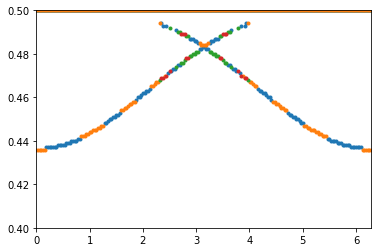

In [13]:
for p in range(len(EJdisp)):
    pp.plot(phiarray,EJdisp[p],'.')
pp.axis([0,2*np.pi,.4,.5])

In [11]:
print(GammaL,GammaR,delta,ET)

(1.0, 1.0, 0.5, 4.214888838624436)


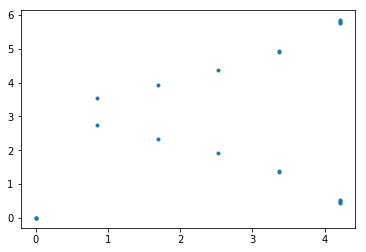

In [10]:
pp.plot(PDB,PDphi,'.')

In [12]:
EJdisp16=EJdisp

In [15]:
phi

6.283185307179586